In [35]:
import numpy as np 
from scipy.optimize import minimize 
from scipy import linalg 
import matplotlib.pyplot as plt
import random
%matplotlib inline

# np.random.seed(0) 
N = 100 
half_n = N//2 
r = 10 
s = r/16 
t = np.random.uniform(0, 2*np.pi, half_n) 
n = s*np.random.randn(half_n) 
x1 , y1 = (r + n)*np.cos(t), (r + n)*np.sin(t) 
X_circ = np.hstack((x1.reshape(half_n, 1) , y1.reshape(half_n , 1))) 

m, b = -1, 2 
x2 = np.linspace(-12, 12 , half_n) 
y2 = m*x2 + b + s*np.random.randn(half_n) 
X_line = np.hstack((x2.reshape(half_n , 1) , y2.reshape(half_n , 1))) 
X = np.vstack((X_circ , X_line))
y=y1 + y2


In [36]:
class RANSAC:
    '''this class performs the RANSAC algorithm'''
    def __init__(self,x_data,y_data,min_samples,dis_thres,num_samps):
        # initialize the variables
        self.x_data=x_data
        self.y_data=y_data
        self.s=min_samples # minimum number of points that need to choose
        self.t=dis_thres # the thresh hold distance for comparison
        self.N=num_samps # the number of samples required to get reasonable accuracy
        self.best_model=None
        self.inliers=[]
        self.outliers=[]
        self.points=[]

    def distance(self,p1,p2): # calculate the distance between two points
        return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5

    def random_sample(self): # generate random sample of data points
        self.points=[]
        i=0
        while i<self.s:
            ind=random.randint(0,len(self.x_data)-1)
            pnt=(self.x_data[ind],self.y_data[ind])
            if pnt not in self.points: # avoid duplicating points
                self.points.append(pnt)
                i+=1

    def circle_equation(self): # calculate the equation of a circle
        pt1,pt2,pt3=self.points
        Y = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]])
        Z = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])
        inverse_Y = linalg.inv(Y)
        c_x, c_y = np.dot(inverse_Y, Z) / 2
        cx, cy = c_x[0], c_y[0]
        r = np.sqrt((cx - pt1[0])**2 + (cy - pt1[1])**2)
        return cx, cy, r # return the center coordinates and the radius

    def inliers_filter(self):
        # calculate the inliers and outlier
        new_inliers=[]
        new_outliers=[]
        xc,yc,r=self.circle_equation()
        for i in range(len(self.x_data)):
            dist=self.distance((self.x_data[i],self.y_data[i]),(xc,yc))
            if abs(dist-r)<=self.t:
                new_inliers.append((self.x_data[i],self.y_data[i]))
            else:
                new_outliers.append((self.x_data[i],self.y_data[i]))
        if len(self.inliers)<len(new_inliers): # update the best model using calculated data
            self.inliers=new_inliers
            self.outliers=new_outliers
            self.best_model=(xc,yc,r)

    def model_finder(self): # find the best fitting model by iterating N times
        for i in range(self.N):
            self.random_sample()
            self.inliers_filter()
        return self.best_model   

In [37]:
# finding the best sample
best_samp=RANSAC(X[:,0],X[:,1],3,1,35)
best_samp.model_finder()

(-0.2523494216729366, 0.15295598488309084, 9.850701393400499)

In [38]:
# using the data of the best sample, find the RANSAC estimation
ransac=RANSAC(np.array(best_samp.inliers)[:,0],np.array(best_samp.inliers)[:,1],3,1,35)
ransac.model_finder() 

(0.22272477321805884, 0.5586061029660001, 9.991807914576873)

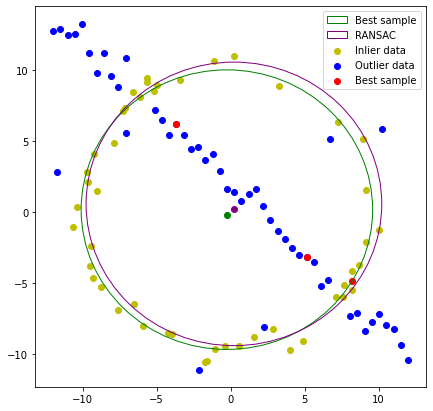

In [39]:
fig,ax=plt.subplots(figsize=(7,7))
ax.scatter(np.array(best_samp.inliers)[:,0],np.array(best_samp.inliers)[:,1],c='y',label='Inlier data')
ax.scatter(np.array(best_samp.outliers)[:,0],np.array(best_samp.outliers)[:,1],c='b',label='Outlier data')

circle1 = plt.Circle((best_samp.best_model[0], best_samp.best_model[1]), best_samp.best_model[2], color='green',fill=False,label='Best sample')
ax.add_patch(circle1)

circle2 = plt.Circle((ransac.best_model[0], ransac.best_model[1]), ransac.best_model[2], color='purple',fill=False,label='RANSAC')
ax.add_patch(circle2)

ax.scatter(np.array(best_samp.points)[:,0],np.array(best_samp.points)[:,1],c='r',label='Best sample')
ax.scatter(best_samp.best_model[0],best_samp.best_model[0],c='green')
ax.scatter(ransac.best_model[0],ransac.best_model[0],c='purple')
ax.legend(loc='upper right')
plt.show()

In [40]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

dst_points=[]
def get_coord(img_name):
    global dst_points
    img=cv.imread(img_name)
    count=0
    def click_event(event, x, y, flags, params):
        if event==cv.EVENT_LBUTTONDOWN:
            dst_points.append([x,y])
            cv.circle(img, (x,y), 2, [0,0,255], 2)
            cv.imshow('image', img)
        
    cv.namedWindow('image',cv.WINDOW_AUTOSIZE)    
    cv.imshow('image', img)
    cv.setMouseCallback('image', click_event)
    while count<4:
        cv.waitKey(1) 
        count+=1
        
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    return dst_points

def homography(img_fg,img_bg):
    fh,fg=img_fg.shape[0],img_fg.shape[1]
    pts_src = np.array([[0, 0], [0, fg], [fh, 0],[fh, fg]])
    pts_dst = np.array(get_coord('hall.jpg'))

    h, status = cv.findHomography(pts_src, pts_dst)
    im_out = cv.warpPerspective(img_fg, h, (img_bg.shape[1],img_bg.shape[0]))
    return im_out

def plot_align(img_fg,img_bg):
    fig,ax=plt.subplots(1,1,figsize=(6,6))
    ax.imshow(cv.cvtColor(cv.addWeighted(img_bg,1,homography(img_fg,img_bg),0.5,0), cv.COLOR_BGR2RGB))
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()

img_hall=cv.imread(r'hall.jpg')
assert img_hall is not None
img_flag=cv.imread(r'sri lankan flag.png')
assert img_flag is not None


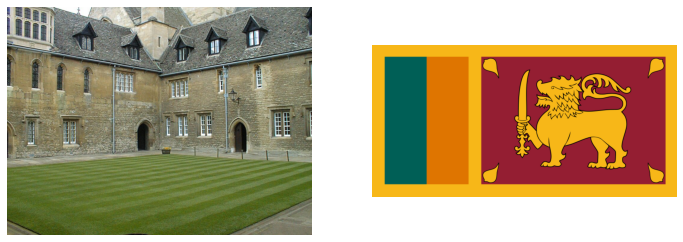

In [41]:
fig,ax=plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(cv.cvtColor(img_hall, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(img_flag, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [42]:
img_hall.shape

(768, 1024, 3)

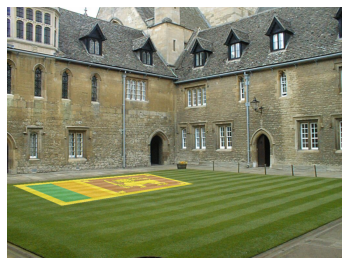

In [43]:
plot_align(img_flag,img_hall)

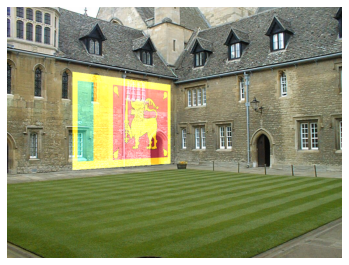

In [58]:
pts_src = np.array([[0, 0], [0, 400], [800, 0],[800, 400]])
pts_dst = np.array([[200, 200], [200,500], [500,240],[500,480]])
h, status = cv.findHomography(pts_src, pts_dst)
im_out = cv.warpPerspective(img_flag, h, (img_hall.shape[1],img_hall.shape[0]))

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.imshow(cv.cvtColor(cv.add(img_hall,im_out), cv.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

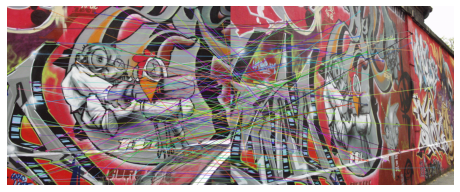

In [44]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

img1=cv.imread(r'graf/img1.ppm')
assert img1 is not None
img5=cv.imread(r'graf/img5.ppm')
assert img5 is not None

gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray5 = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()

key_p1, des1 = sift.detectAndCompute(gray1,None)
key_p5, des5 = sift.detectAndCompute(gray5,None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des5,k=2)

good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append([m])

img_new = cv.drawMatchesKnn(img1,key_p1,img5,key_p5,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(cv.cvtColor(img_new,cv.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

In [52]:
src_pts = 0
dst_pts = 0
dst_pts = np.float32([key_p1[m[0].queryIdx].pt for m in good]).reshape(-1, 2)
src_pts = np.float32([key_p5[m[0].trainIdx].pt for m in good]).reshape(-1, 2)


def random_points(src_pts, dst_pts, N):
    rnd = np.random.choice(len(src_pts), N)
    src = [src_pts[i] for i in rnd]
    dst = [dst_pts[i] for i in rnd]
    return np.asarray(src, dtype=np.float32), np.asarray(dst, dtype=np.float32)


def H_mat(src, dst, N):
    A = []
    for i in range(N):
        x, y = src[i][0], src[i][1]
        x_p, y_p = dst[i][0], dst[i][1]
        A.append([x, y, 1, 0, 0, 0, -x * x_p, -x_p * y, -x_p])
        A.append([0, 0, 0, x, y, 1, -y_p * x, -y_p * y, -y_p])
    A = np.asarray(A)
    u, s, vh = np.linalg.svd(A)
    l = vh[-1, :] / vh[-1, -1]
    H = l.reshape(3, 3)
    return H


def ransac_homography(src_pts, dst_pts):
    I = 0
    Src = []
    Dst = []
    n=600
    for i in range(n):
        src_pnt, dst_pnt = random_points(src_pts, dst_pts, 4)
        H = H_mat(src_pnt, dst_pnt, 4)
        inlines = 0
        src_lines = []
        dst_lines = []
        for p, q in zip(src_pts, dst_pts):
            p1U = (np.append(p, 1)).reshape(3, 1)
            qe = H.dot(p1U)
            qe = (qe / qe[2])[:2].reshape(1, 2)[0]
            if cv.norm(q - qe) < 50:
                inlines += 1
                src_lines.append(p)
                dst_lines.append(q)
        if inlines > I:
            I = inlines
            Src = src_lines.copy()
            Src = np.asarray(Src, dtype=np.float32)
            Dst = dst_lines.copy()
            Dst = np.asarray(Dst, dtype=np.float32)
    H_f = H_mat(Src, Dst, I)
    return H_f



In [53]:
H = ransac_homography(src_pts, dst_pts)

H_given=[]
with open(r'graf/H1to5p') as f:
    H_given=np.array([[float(h) for h in line.split()] for line in f])
    

In [54]:
print('H - calculated')
H

H - calculated


array([[-7.88432359e-01, -6.10565988e-01,  3.56294253e+02],
       [-2.24412165e-01, -5.00023966e-01,  1.87896633e+02],
       [-1.57635027e-03, -1.98117609e-03,  1.00000000e+00]])

In [55]:
print('H - given')
H_given

H - given


array([[ 6.2544644e-01,  5.7759174e-02,  2.2201217e+02],
       [ 2.2240536e-01,  1.1652147e+00, -2.5605611e+01],
       [ 4.9212545e-04, -3.6542424e-05,  1.0000000e+00]])

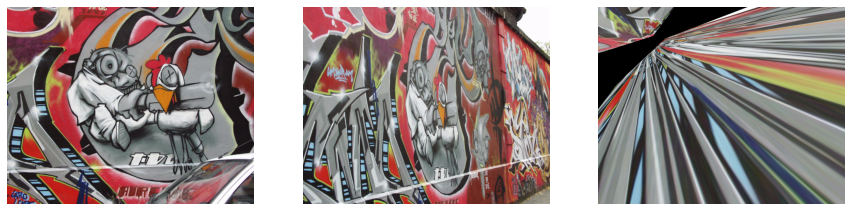

In [56]:
#img1to5=cv.warpPerspective(img5,np.linalg.inv(H),((img1.shape[1] + img5.shape[1]), img5.shape[0]))
dst = cv.warpPerspective(img5,H, ((img1.shape[1] + img5.shape[1]), img5.shape[0]+ img5.shape[0])) #wraped image

fig,ax=plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(cv.cvtColor(img1,cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].imshow(cv.cvtColor(img5,cv.COLOR_BGR2RGB))
ax[1].axis('off')
ax[2].imshow(cv.cvtColor(dst,cv.COLOR_BGR2RGB))
ax[2].axis('off')
plt.show()